In [1]:
#
# Examples mostly taken from:
#    https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy
#
# Additional examples can be found at:
#    https://www.vitoshacademy.com/python-making-maps-with-cartopy/
#
# Longitude and Latitude information can be found at:
#    https://www.geonames.org
# Or just ask Google
#

In [2]:
import io
import csv
import numpy as np
import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from geopy import geocoders
from shapely.geometry import LineString, MultiLineString
from urllib.request import urlopen, Request
from PIL import Image
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

#class StadiaStamen(cimgt.Stamen):
#    def _image_url(self, tile):
#         x,y,z = tile
#         url = f"https://tiles.stadiamaps.com/tiles/stamen_terrain_background/{z}/{x}/{y}.png?api_key={1587e1e7-daf3-43fa-847a-3f5a8a059c09}"
#         return url

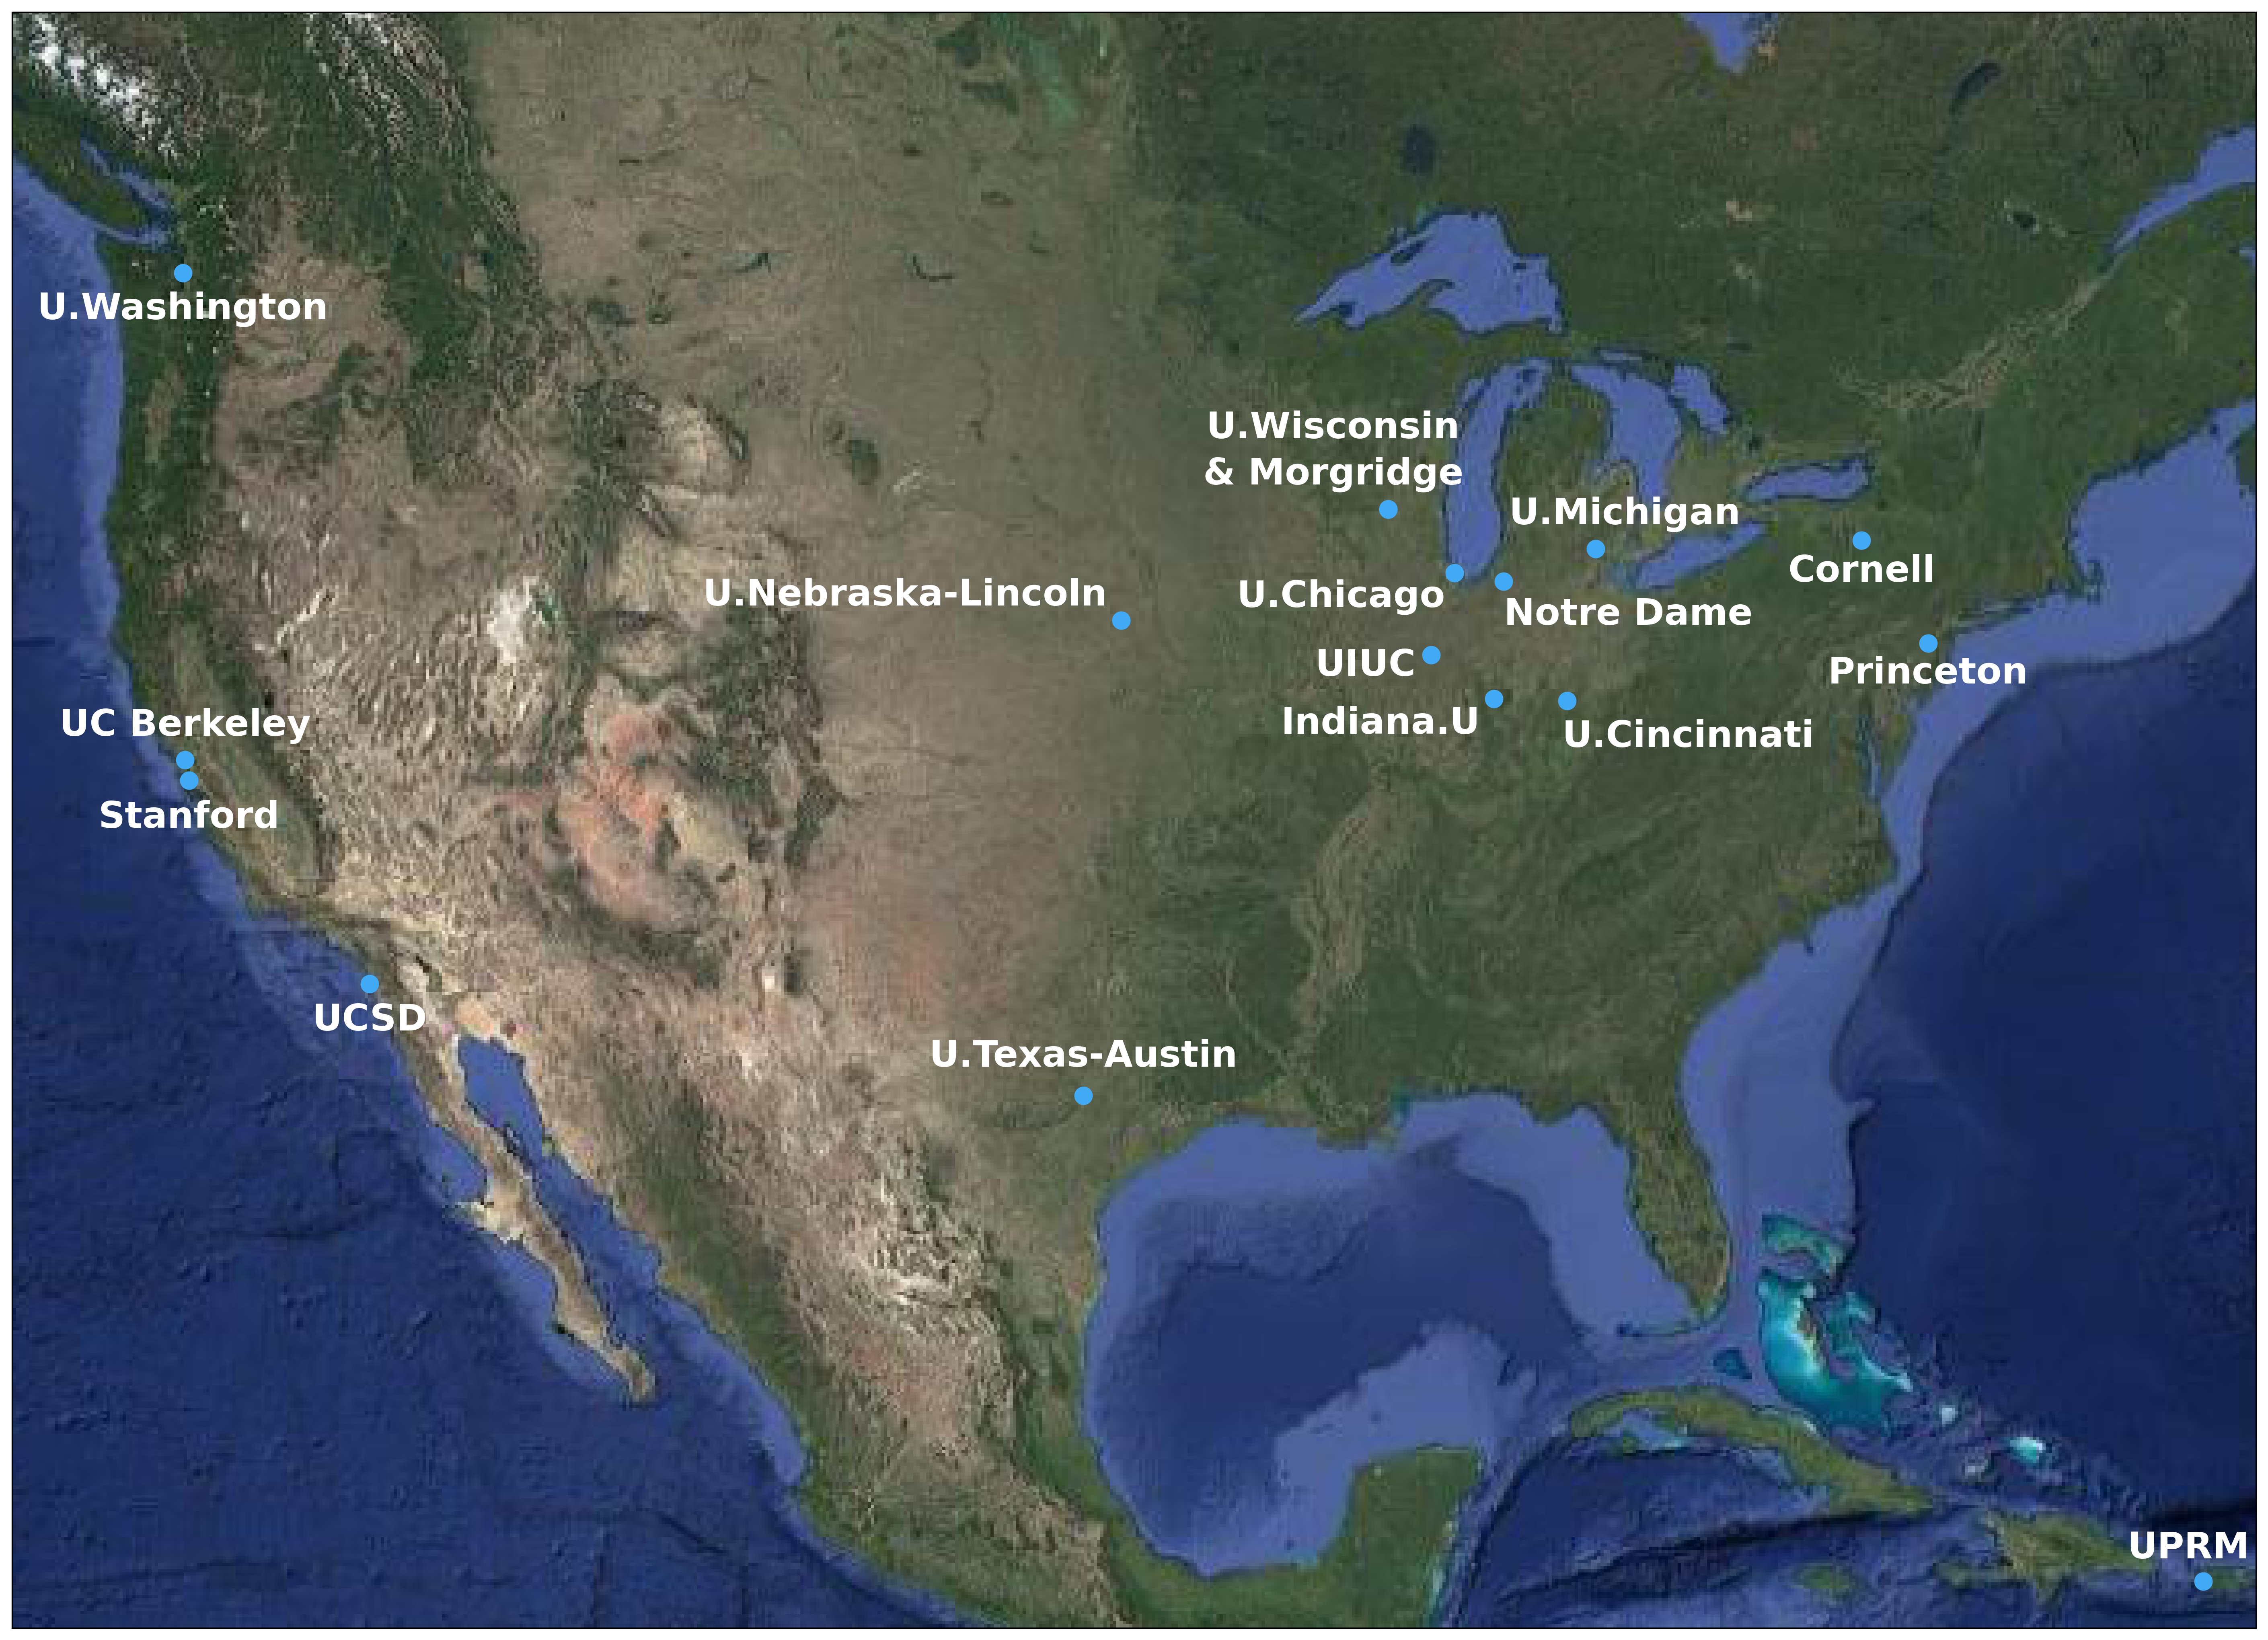

In [3]:
# Mapping a set of collaborating research institutions in the United States
# This code uses a spoofing algorithm to avoid bounceback from OSM servers

def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

def get_institutions_info(filename,names,lats,lons,labellats,labellons):
    with open(filename,'r') as dat_file:
        reader = csv.reader(filter(lambda row: row[0]!='#',dat_file), delimiter=',')
        for row in reader:
            latitude = float(row[2])
            longitude = float(row[4])
            if (row[3].strip() == 'S'):
                latitude = -1.0 * latitude
            if (row[5].strip() == 'W'):
                longitude = -1.0 * longitude
            if (row[1]):
                names.append(row[0].strip() + "\n" + row[1].strip())
            else:
                names.append(row[0].strip())
            lats.append(latitude)
            lons.append(longitude)
            labellats.append(latitude+float(row[6]))
            labellons.append(longitude+float(row[7]))
            #print ('University = ' + row[0].strip() + '  ' + str(round(latitude,1)) + '  ' + str(round(longitude,1)))


names0,lats0,lons0,labellats0,labellons0 = [],[],[],[],[]
names1,lats1,lons1,labellats1,labellons1 = [],[],[],[],[]
names2,lats2,lons2,labellats2,labellons2 = [],[],[],[],[]

# Comment/uncomment just one of the following to obtain the corresponding map
# Use the "0" variables if you just have a single list
#get_institutions_info('master-list.csv',names0,lats0,lons0,labellats0,labellons0)
#get_institutions_info('example-collaboration.csv',names0,lats0,lons0,labellats0,labellons0)
#get_institutions_info('iris-hep.csv',names0,lats0,lons0,labellats0,labellons0) # use extent below with Puerto Rico
#get_institutions_info('iris-hep-with-pvamu.csv',names0,lats0,lons0,labellats0,labellons0) # use extent below with Puerto Rico
get_institutions_info('iris-hep-v2.0.csv',names0,lats0,lons0,labellats0,labellons0) # use extent below with Puerto Rico
#get_institutions_info('clariphy.csv',names0,lats0,lons0,labellats0,labellons0) # use extent below with Puerto Rico

# One can also plot two sets of points - uncomment two of the lines below and use "0" variables for one and
# the "1" variables for the other (blue points for "0", red points for "1")
#get_institutions_info('iris-hep.csv',names0,lats0,lons0,labellats0,labellons0) # use extent below with Puerto Rico
#get_institutions_info('clariphy.csv',names1,lats1,lons1,labellats1,labellons1) # use extent below with Puerto Rico

# One can also plot three sets of points - this can be useful when there is some overlap
#get_institutions_info('iris-hep-only.csv',names0,lats0,lons0,labellats0,labellons0) # use extent below with Puerto Rico
#get_institutions_info('clariphy-only.csv',names1,lats1,lons1,labellats1,labellons1) # use extent below with Puerto Rico
#get_institutions_info('iris-hep-clariphy-both.csv',names2,lats2,lons2,labellats2,labellons2) # use extent below with Puerto Rico

#######################################
# Formatting the Cartopy plot 
#######################################

cimgt.Stamen.get_image = image_spoof # reformat web request for street map spoofing

#osm_img = cimgt.Stamen('terrain-background') # spoofed, downloaded street map
#osm_img = cimgt.Stamen('watercolor') # spoofed, downloaded street map
#osm_img = cimgt.StadiaMapsTiles('1587e1e7-daf3-43fa-847a-3f5a8a059c09', style='stamen_terrain')
#osm_img = cimgt.StadiaMapsTiles('1587e1e7-daf3-43fa-847a-3f5a8a059c09', style='stamen_watercolor')
#osm_img = cimgt.StadiaMapsTiles('1587e1e7-daf3-43fa-847a-3f5a8a059c09', style='stamen_outdoors')
osm_img = cimgt.GoogleTiles(style='satellite')   # also 'street', 'terrain', 'only_streets'
#osm_img = cimgt.MapQuestOpenAerial()   # doesn't seem to work
#osm_img = cimgt.OSM() # some extra city/location labels
#osm_img = cimgt.OrdnanceSurvey() # requires api-key

#######################################
# Create the map
#######################################

fig = plt.figure(figsize=(24,18),dpi=300)      # open matplotlib figure (figsize default units are inches)
ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map

# Choose the portion of the map to show
#extent = [-127,-65, 24, 46] # Continental US bounds
#extent = [-124.7844079,-66.9513812, 24.7433195, 49.3457868] # Contiguous US bounds
extent = [-127,-65.7, 17, 48] # Contiguous US bounds including Puerto Rico
#extent = [-85,-65, 35, 41] # Maryland/Virginia
#extent = [-125,-115, 30, 40] # SoCal
#extent = [-80,-68, 35, 45] # Northeast
#extent = [-150,150, -75, 75] # Contiguous US bounds
#extent = [-74.257159,-73.699215,40.495992,40.915568] # NYC bounds
ax1.set_extent(extent) # set extents

# Uncomment the following lines for latitude and longitude axis labels
#ax1.set_xticks(np.linspace(extent[0],extent[1],7),crs=ccrs.PlateCarree()) # set longitude indicators
#ax1.set_yticks(np.linspace(extent[2],extent[3],7)[1:],crs=ccrs.PlateCarree()) # set latitude indicators
#lon_formatter = LongitudeFormatter(number_format='0.1f',degree_symbol='',dateline_direction_label=True) # format lons
#lat_formatter = LatitudeFormatter(number_format='0.1f',degree_symbol='') # format lats
#ax1.xaxis.set_major_formatter(lon_formatter) # set lons
#ax1.yaxis.set_major_formatter(lat_formatter) # set lats
#ax1.xaxis.set_tick_params(labelsize=14)
#ax1.yaxis.set_tick_params(labelsize=14)

# Make the base plot
scale = np.ceil(-np.sqrt(2)*np.log(np.divide((extent[1]-extent[0])/2.0,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
ax1.add_image(osm_img, int(scale)) # add OSM with zoom specification

#######################################
# Plot the institutions as points
#######################################
#
# Plot the points - the size, marker type and point color can be set here
# Assume up to three lists. If a list is empty, nothing is plotted.
points0 = ax1.plot(lons0, lats0, markersize=10,marker='o',linestyle='',color='#42aaf5',transform=ccrs.PlateCarree())
points1 = ax1.plot(lons1, lats1, markersize=10,marker='o',linestyle='',color='#ff0000',transform=ccrs.PlateCarree())
points2 = ax1.plot(lons2, lats2, markersize=10,marker='o',linestyle='',color='#d916e9',transform=ccrs.PlateCarree())

transform = ccrs.PlateCarree()._as_mpl_transform(ax1) # set transform for annotations

# Uncomment if a legend is useful
#ax1.legend(['LABEL1','LABEL2','LABEL3'])
#ax1.text(-90.0,42.0,'FOO', {'color': 'k', 'fontsize': 8},
#                 horizontalalignment='center', verticalalignment='bottom',
#                 clip_on=False,transform=transform,bbox=dict(boxstyle="none",
#                   ec='#121212', fc='#ffffff'))
#ax1.text(-90.5,43.0,'FOO', {'color': '#000000', 'weight': 'bold', 'fontsize': 10},
#                 horizontalalignment='center', verticalalignment='bottom',
#                 clip_on=False, transform=transform)

# Uncomment/comment the following to add/remove the labels
# We assume up to three lists (nothing gets added if a list is empty from above)
i=0
while i < len(names0):
   ax1.text(labellons0[i],labellats0[i],names0[i], {'color': '#ffffff', 'weight': 'bold', 'fontsize': 22},
                 horizontalalignment='center', verticalalignment='bottom',
                 clip_on=False, transform=transform)
   i+=1

i=0
while i < len(names1):
   ax1.text(labellons1[i],labellats1[i],names1[i], {'color': '#000000', 'weight': 'bold', 'fontsize': 10},
                 horizontalalignment='center', verticalalignment='bottom',
                 clip_on=False, transform=transform)
   i+=1

i=0
while i < len(names2):
   ax1.text(labellons2[i],labellats2[i],names2[i], {'color': '#000000', 'weight': 'bold', 'fontsize': 10},
                 horizontalalignment='center', verticalalignment='bottom',
                 clip_on=False, transform=transform)
   i+=1    

# Make the graphic
plt.show()